<a href="https://colab.research.google.com/github/bimewok/predicting_tides/blob/main/predicting_tides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we will compare several different types of recurrent neural networks applied to predict the hourly tide height for the next seven days. Although predicting tides is a solved problem, this problem is ideal for demonstrating the use of neural networks due to the complex yet predictable nature of tides. Using datasets like this can serve as a means to test models for more complex problems as sometimes it can be unclear whether the model is poorly performant of the data trend is truely unpredictable when working to solve more complex problems. 

We will use:
- Simple RNN
- LSTM
- GRU
- Conv RNN



In [1]:
import pandas as pd
import copy
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error
import requests, io
from IPython.core.display import display 

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('Ready to Go!')

Ready to Go!


# Background

Tides are caused by gravitational forces of the moon, and to a lesser extent, the sun. Additionally, local tides are controled by coastline geography and bathymetry (surbsurface depth and shape). Although we can predict moon and sun position with high accuracy, the abiity to map the ocean's sub-surface at large scale and with high resolution is very new. The NOAA predicts tides using years of historical data and fairly sophisticated sine-wave algorythms that are tuned to a local vertical sea level datum. More information about the current NOAA methodology can be found here:

https://tidesandcurrents.noaa.gov/restles1.html

Their method does not use machine learning. The goal of this project is not to improve their method. This is a solved ploblem and this project simply aims to demonstrate the use of behaviour of several NN's for predicting mult-scale trends. 

# The Data

Tides have been recorded in many harbours for centuries. Thus, there is an abundance of available tide height data for most port cities around the world. I choose to use a dataset of hourly ocean height measurements since 1911 for the Victoria, BC harbour. The dataset source is: 

http://uhslc.soest.hawaii.edu/data/

Caldwell, P. C., M. A. Merrifield, P. R. Thompson (2015), Sea level measured by tide gauges from global oceans — the Joint Archive for Sea Level holdings (NCEI Accession 0019568), Version 5.5, NOAA National Centers for Environmental Information, Dataset, doi:10.7289/V5V40S7W.

## Download the Data

In [2]:
file = requests.get('https://raw.githubusercontent.com/bimewok/predicting_tides/main/data/tides.csv').content

#leave blank for working directory. Or e.g. r'C:\garrett_workspace\PROJECTS\tides'
save_path = ''
tides = pd.read_csv(io.StringIO(file.decode('utf-8')))

## Clean the Data

In exploring the data, it is obbious that '-32767' as a value for height is clearly representative of a missing value or bad measurement. Thus, we will interpolate those values based on past and previous observations. 

**The height measurements are in centimeters.**

In [3]:
def clean_data(data=tides):
  data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
  data = data.replace({-32767: np.nan})
  data = data.interpolate(method='linear')
  return data

data = clean_data()

display(data[242358:242368])

,year,month,day,hour,height,date
242358,1936.0,10.0,12.0,15.0,1370.0,1936-10-12 15:00:00
242359,1936.0,10.0,12.0,16.0,1461.0,1936-10-12 16:00:00
242360,1936.0,10.0,12.0,17.0,1674.0,1936-10-12 17:00:00
242361,1936.0,10.0,12.0,18.0,1857.0,1936-10-12 18:00:00
242362,1936.0,10.0,12.0,19.0,2040.0,1936-10-12 19:00:00
242363,1936.0,10.0,12.0,20.0,2193.0,1936-10-12 20:00:00
242364,1936.0,10.0,12.0,21.0,2315.0,1936-10-12 21:00:00
242365,1936.0,10.0,12.0,22.0,2284.0,1936-10-12 22:00:00
242366,1936.0,10.0,12.0,23.0,2162.0,1936-10-12 23:00:00
242367,1936.0,10.0,13.0,0.0,1979.0,1936-10-13 00:00:00


# Visualize Trends

Here we will look at two charts: <br>
1) Average tide height across all dates on a daily, weekly, annual and all time basis. This will show us global trends in the data. <br>
2) Visualization of a random day, week, month of sequential data. 

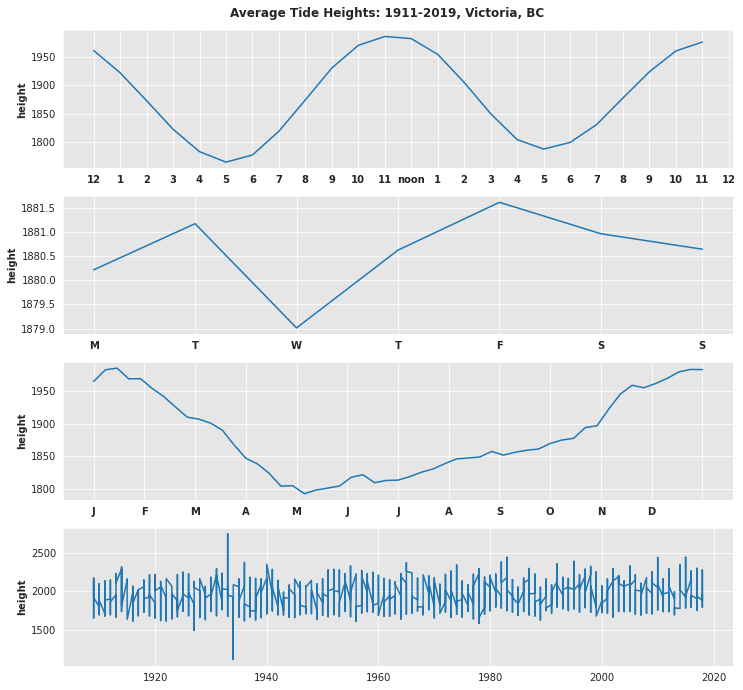

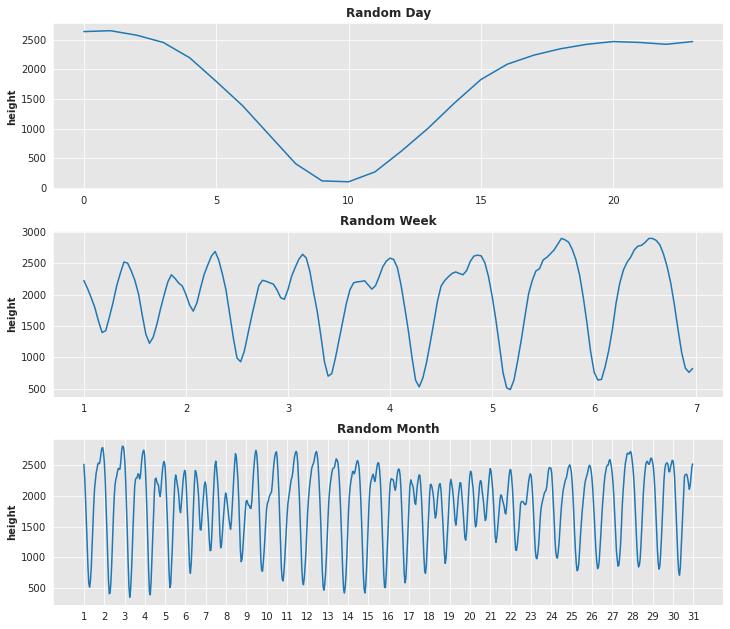

In [4]:
def vis_global_avgs(data=data):
    day_of_week_means = pd.DataFrame(data.groupby([data['date'].dt.dayofweek]).mean())
    time_of_day_means = pd.DataFrame(data.groupby([data['date'].dt.hour, data['date'].dt.minute]).mean())
    yearly_change_means = pd.DataFrame(data.groupby([data['date'].dt.year, data['date'].dt.isocalendar().week]).mean())
    annual_means = pd.DataFrame(data.groupby([data['date'].dt.isocalendar().week]).mean())
    
    day_of_week_means['series'] = np.arange(len(day_of_week_means))
    
    time_of_day_means['series'] = np.arange(len(time_of_day_means))
    
    yearly_change_means['series'] = np.arange(len(yearly_change_means))
    annual_means['series'] = np.arange(float(len(annual_means)))
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
    
    fig.set_size_inches(12, 10.7)
    #fig.subplots_adjust(hspace=0.25)
    fig.suptitle('Average Tide Heights: 1911-2019, Victoria, BC', fontweight='bold')
    fig.subplots_adjust(top=0.95)
    
    
    ax1.plot(time_of_day_means['series'], time_of_day_means['height'])
    ax1.set_xticks([*range(0, 25, 1)])
    ax1.set_xticklabels(['12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 'noon', 
                         '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], fontweight='bold')
    
    ax1.grid(True)
    ax1.set_ylabel('height', fontweight='bold')
    
    ax2.plot(day_of_week_means['series'], day_of_week_means['height'])
    
    
    ax2.set_xticks([*range(0, 7)])
    ax2.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'], fontweight='bold')
    ax2.grid(True)
    ax2.set_ylabel('height', fontweight='bold')
    
    ax3.plot(annual_means['series'], annual_means['height'])
    ax3.set_xticks(np.linspace(0., max(annual_means['series']), num=13))
    ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', ''], fontweight='bold')
    
    ax3.grid(True)
    ax3.set_ylabel('height', fontweight='bold')
    
    ax4.plot(yearly_change_means['year'], yearly_change_means['height'])
    ax4.grid(True)
    ax4.set_ylabel('height', fontweight='bold')
    
    
def vis_random_sequences(data=data):
    r = [2928, 373849, 48167]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(12, 10.7)
    ax1.plot(range(0,24), data['height'][r[0]:r[0]+24])
    ax1.set_title('Random Day', fontweight='bold')
    ax1.set_ylabel('height', fontweight='bold')
    
    ax2.plot(range(0,168), data['height'][r[1]:r[1]+168])
    ax2.set_title('Random Week', fontweight='bold')
    ax2.set_ylabel('height', fontweight='bold')
    ax2.set_xticks(np.linspace(0, 168, num=7))
    ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7])
    
    ax3.plot(range(0,744), data['height'][r[2]:r[2]+744])
    ax3.set_title('Random Month', fontweight='bold')
    ax3.set_ylabel('height', fontweight='bold')
    ax3.set_xticks(np.linspace(0, 744, num=31))
    ax3.set_xticklabels([*range(1, 32, 1)])
   
    fig.subplots_adjust(hspace=0.25)
    plt.show()
    
vis_global_avgs()
vis_random_sequences()

data = data.drop(['year', 'month', 'day', 'hour', 'date'], axis=1)

These charts show a few important things:<br>
1) High tide is more common around noon or midnight that other times of day<br>
2) The highest tides of the year are in winter<br>
3) There may be a slight trend in increasing heights over time. This could be checked with a simple T-test, however that is not the purpose of this demo <br>
4) There were two particularly high and low tide period's in the 1930's. It may be bad data or an anomoly (storm surge). This could be replaced with 'more typical' values to improve model performace, however it may be important to for the predicting tidal flooding. We can investigate this later.

Conclusion: There are trends ocurring at multiple time scales and it will be interesting to see if the models can adequitely generalize all patterns in the data. 

# Prepare Data

Recurrent nueral networks take in windows of sequential observations and make predictions based on what is observed in the window. These models can be designed to predict:<br>
- a single value for each window (i.e. the ocean height in 7 days)<br>
-  multiple values for each window (an hourly prediction for the nect 7 days) <br>
- a sequence of predictions for each observation in the window (called sequence to sequence)

In this project, the models have been designed to predict sequences as this increases the number of gradients for the model to generalize from.

To summarize, **The model will take in a window of historic observations (x) and predict the next n future values (y) for each observation.**

Here `future_steps` is the number of timesteps in the future to predict (168 hours / 24 hours = 1 week) and `past_steps` is the number of historic observations to base the model's decision on. `y_position` is simply the column number the variable of interest sits at in a dataframe. This dataset is univariate but can easily by applied to multi-variate datasets. 

In [5]:
future_steps = 168
past_steps = 168
y_position = 0
train_size = 0.7

## Split and Scale Data

Here we split the data into a trainin, validation and test dataset and scale the data to a value between 0 and 1.

In [6]:
def split_df(df=data, tr_size=train_size):
    length = len(df)
    train_end = int(tr_size*length)
    val_end = int(train_end+(((1-tr_size)/2)*length))
    
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, test, val

train, test, val = split_df()

def scale_data(train=train, val=val, test=test):
    maxes = []
    
    for col in train.columns:
        maxes.append(max(train[col]))
    for i in range(len(maxes)):
        train.iloc[:,i] = train.iloc[:,i] / maxes[i]
        val.iloc[:,i] = val.iloc[:,i] / maxes[i]
        test.iloc[:,i] = test.iloc[:,i] / maxes[i]
    return train, val, test, maxes

train, val, test, maxes = scale_data()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Reshape Data

As mentined above, the x data needs to be windowed and the y data needs to be reshaped to math the windows. The standard format for time series windowed data in a Keras model is a 3d array:<br>
**(number of windows, window size, data dimensionality)**<br>

Where:<br>


**window size** is the number of past observations per window. In this case, if the window size is 168, the window will contain 168 'rows' of one hour each.<br>

**data dimensonality** is the number of values for each observation in the dataset. In this case, for our x data, we are simply using a single feature, 'heights'. You could use any number of features depending on your problem. For example, you could add a feature to this dataset called 'moon_phase' and calculate a numeric values representing phase for each of the dates... For our y data, the dimensionality is the number of future time steps we want to predict, since we want to output a vector of future observations.<br>

**number of windows** is defined by your dataset size. This is the number of windows your data can create given its length. You can create sliding / overlapping windows where each window contains most of the same observations as the last, but just bumped forward n timesteps. Thus you can still create a fairly large number of windows with even a small dataset, but in my experience this can lead to overfitting. Thus, we will only use exclusive windows of fixed size. 

The below function takes in a dataframe, y column location, and the window shape metrics and outputs a 3d x and y arrray. 


In [7]:
def reshape_data(df, y_position, past_steps, future_steps):
    y_intermediate = df.iloc[:,y_position]
    y = []
    for i in range(len(y_intermediate)):
        if i <= (len(y_intermediate) - (future_steps+1)):
            y.append(y_intermediate.iloc[i+1:i+1+(future_steps)])
            if i % 90000 == 0:
                print(round((i/len(y_intermediate))*100, 0), '%')
    df = df.head(len(y))
    num_batches = int(len(df) / past_steps)
    if num_batches*past_steps < len(y):
        y = y[:num_batches*past_steps]
        df = df.head(len(y))
      
    y = np.array(y)
    x = np.array(df)
    y = np.reshape(y, (num_batches,past_steps,future_steps))
    x = np.reshape(x, (num_batches,past_steps,len(df.columns)))
    return x, y

print('starting train')
x_train, y_train = reshape_data(train, y_position, past_steps, future_steps)
print('starting validation')
x_val, y_val = reshape_data(test, y_position, past_steps, future_steps)
print('starting test')
x_test, y_test = reshape_data(val, y_position, past_steps, future_steps)

print('x_train shape: ',x_train.shape)
print('y_train_shape: ',y_train.shape)


starting train
0.0 %
13.0 %
27.0 %
40.0 %
53.0 %
67.0 %
80.0 %
93.0 %
starting validation
0.0 %
62.0 %
starting test
0.0 %
62.0 %
x_train shape:  (4011, 168, 1)
y_train_shape:  (4011, 168, 168)


# Build LSTM Model

Here we build a LSTM model to predict the ocean height. Since we only care about the final prediction 168 time steps in the future, We can use a custom metric function that only measures mean squared error from the final prediction. 

In [8]:
def end_sequence_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(name='LSTM_1')

model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=[None, len(train.columns)]))
model.add(keras.layers.Dense(80))
model.add(keras.layers.LSTM(64, return_sequences=True))
   
model.add(keras.layers.TimeDistributed(keras.layers.Dense(future_steps)))


model.compile(loss="mse", optimizer="adam", metrics=end_sequence_mse)
history = model.fit(x_train, y_train, epochs=15,
                    validation_data=(x_val, y_val))

def save_model(model, save_path=save_path):
    print(model.name)
    model_path = str(save_path)+'\\'+str(model.name)+'.h5'
    model.save(model_path)

save_model(model)

Epoch 1/15
126/126 [==============================] - 12s 26ms/step - loss: 0.1079 - end_sequence_mse: 0.1048 - val_loss: 0.0301 - val_end_sequence_mse: 0.0285
Epoch 2/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0246 - end_sequence_mse: 0.0224 - val_loss: 0.0167 - val_end_sequence_mse: 0.0148
Epoch 3/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0156 - end_sequence_mse: 0.0136 - val_loss: 0.0153 - val_end_sequence_mse: 0.0134
Epoch 4/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0132 - end_sequence_mse: 0.0113 - val_loss: 0.0120 - val_end_sequence_mse: 0.0098
Epoch 5/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0102 - end_sequence_mse: 0.0077 - val_loss: 0.0079 - val_end_sequence_mse: 0.0052
Epoch 6/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0072 - end_sequence_mse: 0.0044 - val_loss: 0.0069 - val_end_sequence_mse: 0.0042
Epoch 7/15
126/126 [=========================

## Plot History

This plot shows the scores for each epoch, and can highlight if the model is overfitting or unstable. 

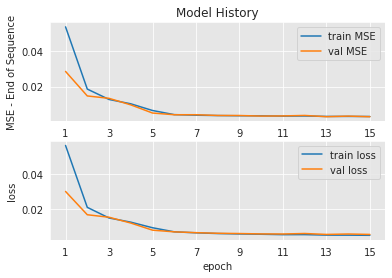

In [9]:
def plot_history(history):
    h = pd.DataFrame(history.history)
    h['epoch'] = h.index + 1
    
    
    plt.subplot(2, 1, 1)
    plt.plot(h['epoch'], h['end_sequence_mse'], h['epoch'], h['val_end_sequence_mse'])
    plt.title('Model History')
    plt.ylabel('MSE - End of Sequence')
    plt.grid(True)
    plt.legend(('train MSE', 'val MSE'),
               loc='upper right')
    plt.xticks(range(1,max(h['epoch'])+1, 2))
    
    
    plt.subplot(2, 1, 2)
    plt.plot(h['epoch'], h['loss'], h['epoch'], h['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(('train loss', 'val loss'),
               loc='upper right')
    plt.xticks(range(1,max(h['epoch'])+1, 2))
    plt.show()

plot_history(history)

# Plot Predictions

The following functions generate predictions using the trained model, and produce 5 plots of predictions for 5 random windows. You can either select one entire sequence at the end of each window to visualize, or you can visuale the last prediction in each sequence for each observation in the batch, as shown below. 

Negative time values on the x-axis refer to historical observations the model has seen at prediction time, and positive time values refer to future times the model has not seen at prediction time. 

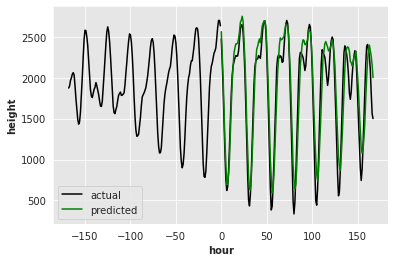

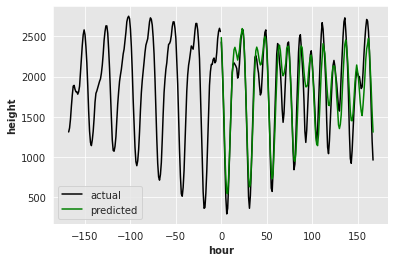

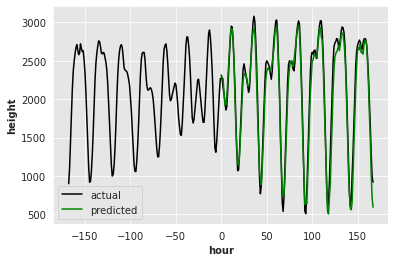

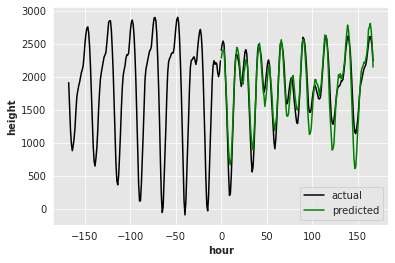

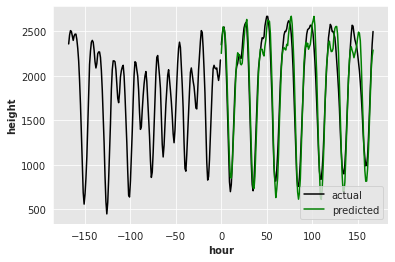

In [10]:
def get_predictions(model, y_test=y_test, x_test=x_test, maxes=maxes, y_pos=y_position):
    y_pred = model.predict(x_test)[:, -1][..., np.newaxis]
    y_pred = y_pred*(maxes[y_pos])
    y_test_rescaled = y_test*(maxes[y_pos])
    x_test_rescaled = np.empty_like(x_test)
    for i in range(len(maxes)):
        x_test_rescaled[:,:,i] = x_test[:,:,i]*maxes[i]
    return x_test_rescaled, y_test_rescaled, y_pred

x_test_rescaled, y_test_rescaled, y_pred = get_predictions(model) 

def plot_predictions(y_pred, x_test_rescaled=x_test_rescaled, y_test_rescaled=y_test_rescaled,  
                     num_to_show=5, past=past_steps, future=future_steps, y_pos=y_position):
    rng = np.random.default_rng()
    array = np.array(rng.integers(len(y_pred +1), size=num_to_show))
    for i in array:
        past_x = x_test_rescaled[i,:,y_pos]
        future_x = y_test_rescaled[i,(past-1),:]
        predictions = y_pred[i]
        
        future_x_axis = range(0, future)
        past_x_axis = range(-past, 0)
        plt.plot(past_x_axis, past_x, color='black')
        plt.plot(future_x_axis, future_x, color='black', label='actual')
        plt.plot(future_x_axis, predictions, color ='green', label='predicted')
        plt.gca().set_ylabel('height', fontweight='bold')
        plt.gca().set_xlabel('hour', fontweight='bold')
        plt.legend()
        plt.show()    

plot_predictions(y_pred)

# Visualize Prediction Distributions

MAE:  164.05935841015764
MAPE:  12.0 %


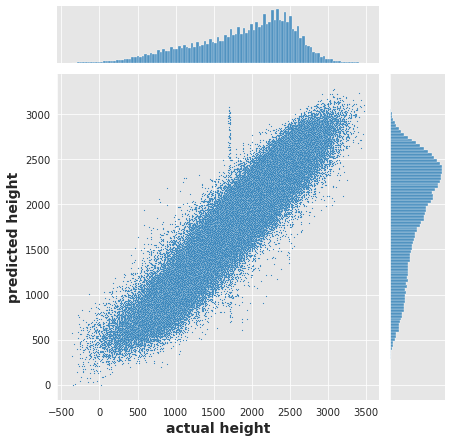

In [11]:
def visualize_results(predictions, y_test_rescaled=y_test_rescaled):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    ax = sns.jointplot(x=np.ravel(y_test_rescaled[:, -1][..., np.newaxis]), y=np.ravel(predictions), kind='scatter', s=1.5)
    ax.set_axis_labels('actual height', 'predicted height', fontsize=14, fontweight='bold')
    
    
visualize_results(y_pred)

def score_model(predictions, y_test_rescaled=y_test_rescaled):
    mae = mean_absolute_error(np.ravel(y_test_rescaled[:, -1][..., np.newaxis]), np.ravel(predictions))
    print('MAE: ', mae)
    diff = abs(np.subtract(np.ravel(predictions), np.ravel(y_test_rescaled[:, -1][..., np.newaxis])))
    div_zero = copy.copy(np.ravel(y_test_rescaled[:, -1][..., np.newaxis]))
    div_zero[div_zero == 0] = 1

    mape = np.divide(diff, div_zero)

    print('MAPE: ',round(np.mean(mape)*100, 1), '%')    
    return mae, np.mean(mape)
mae, mape = score_model(y_pred)


results = pd.DataFrame(columns=['model', 'MAE', 'MAPE', 'saved_as'])
results = results.append({'model': 'LSTM1', 'MAE': mae, 'MAPE': mape, 'saved_as': str(save_path)+'\\'+str(model.name)+'.h5'}, ignore_index=True)
results.to_csv(save_path+'\\'+'results.csv')

These sharts show that the distribution of predicted values is very similar to the distribution of actual values. The closer If the model predicted heiths perfectly, the point cloud would be a narrow line from bottom left to top right. 

MAE is mean absolute error, or the average deviation of predictions to the actual observation in the same units as the observations (cm). MAPE is mean absolute percentage error (how many % wrong is average prediction) which is often a helpful way to think about relative error for units we are less familiar with. However, if many observations have a values near or equal to zero, MAPE will be disproportionately high. For example, if the model predicted 0.9 and the actual value was 0, the % error is infinate, and you therefore must replace 0's with an arbitrary small number. Thus, the MAPE for these values is very high even if the prediction was pretty good. 

# Build GRU Model

Epoch 1/15
126/126 [==============================] - 5s 22ms/step - loss: 0.1598 - end_sequence_mse: 0.1594 - val_loss: 0.0322 - val_end_sequence_mse: 0.0299
Epoch 2/15
126/126 [==============================] - 2s 17ms/step - loss: 0.0312 - end_sequence_mse: 0.0303 - val_loss: 0.0309 - val_end_sequence_mse: 0.0293
Epoch 3/15
126/126 [==============================] - 2s 16ms/step - loss: 0.0299 - end_sequence_mse: 0.0290 - val_loss: 0.0291 - val_end_sequence_mse: 0.0278
Epoch 4/15
126/126 [==============================] - 2s 17ms/step - loss: 0.0274 - end_sequence_mse: 0.0267 - val_loss: 0.0250 - val_end_sequence_mse: 0.0240
Epoch 5/15
126/126 [==============================] - 2s 16ms/step - loss: 0.0233 - end_sequence_mse: 0.0214 - val_loss: 0.0197 - val_end_sequence_mse: 0.0196
Epoch 6/15
126/126 [==============================] - 2s 16ms/step - loss: 0.0184 - end_sequence_mse: 0.0168 - val_loss: 0.0163 - val_end_sequence_mse: 0.0158
Epoch 7/15
126/126 [==========================

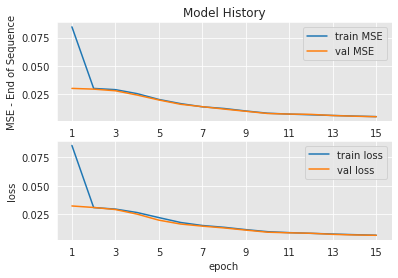

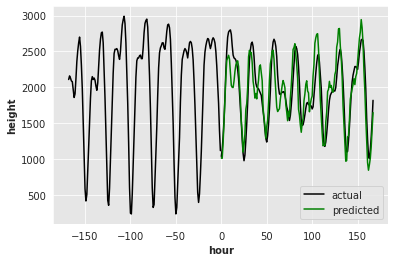

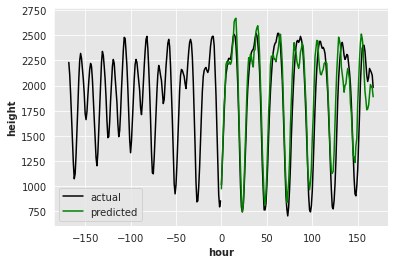

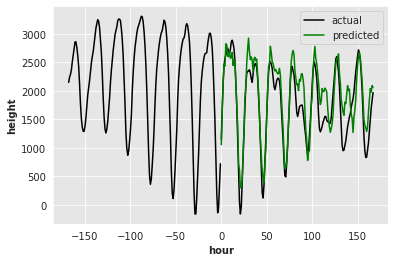

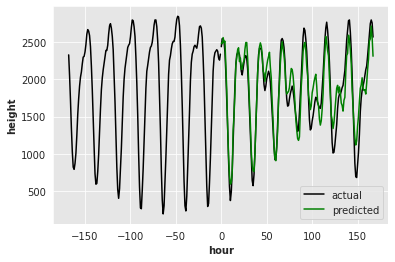

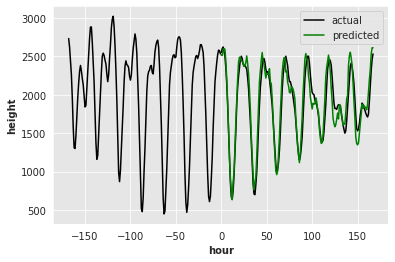

MAE:  190.32682109095393
MAPE:  13.6 %


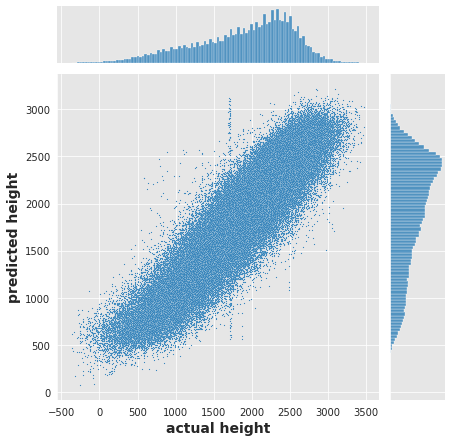

In [12]:
model = keras.models.Sequential(name='GRU_1')


model.add(keras.layers.GRU(20, return_sequences=True, input_shape=[None, len(train.columns)]))
model.add(keras.layers.GRU(20, return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(future_steps)))


model.compile(loss="mse", optimizer="adam", metrics=end_sequence_mse)
history = model.fit(x_train, y_train, epochs=15,
                    validation_data=(x_val, y_val))






save_model(model)
plot_history(history)
x_test_rescaled, y_test_rescaled, y_pred = get_predictions(model) 
plot_predictions(y_pred)
visualize_results(y_pred)
mae, mape = score_model(y_pred)

results = results.append({'model': model.name, 'MAE': mae, 'MAPE': mape, 'saved_as': str(save_path)+'\\'+str(model.name)+'.h5'}, ignore_index=True)
results.to_csv(save_path+'\\'+'results.csv')

# Build Convolutional GRU Model

Epoch 1/20
126/126 [==============================] - 5s 16ms/step - loss: 0.1522 - end_sequence_mse: 0.1503 - val_loss: 0.0316 - val_end_sequence_mse: 0.0298
Epoch 2/20
126/126 [==============================] - 1s 11ms/step - loss: 0.0303 - end_sequence_mse: 0.0297 - val_loss: 0.0288 - val_end_sequence_mse: 0.0278
Epoch 3/20
126/126 [==============================] - 1s 11ms/step - loss: 0.0261 - end_sequence_mse: 0.0258 - val_loss: 0.0192 - val_end_sequence_mse: 0.0183
Epoch 4/20
126/126 [==============================] - 1s 11ms/step - loss: 0.0172 - end_sequence_mse: 0.0166 - val_loss: 0.0153 - val_end_sequence_mse: 0.0145
Epoch 5/20
126/126 [==============================] - 1s 11ms/step - loss: 0.0144 - end_sequence_mse: 0.0135 - val_loss: 0.0142 - val_end_sequence_mse: 0.0134
Epoch 6/20
126/126 [==============================] - 1s 11ms/step - loss: 0.0131 - end_sequence_mse: 0.0120 - val_loss: 0.0124 - val_end_sequence_mse: 0.0112
Epoch 7/20
126/126 [==========================

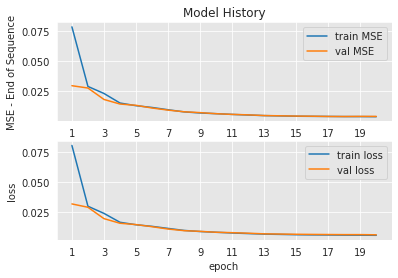

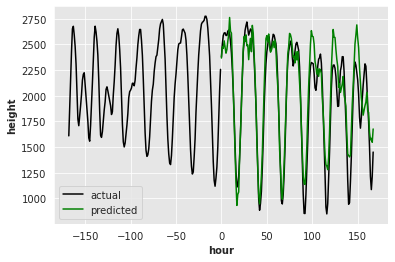

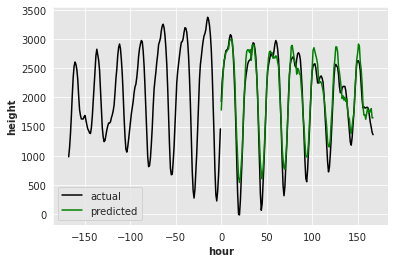

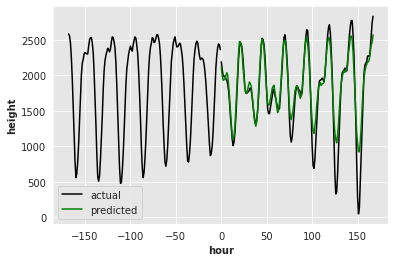

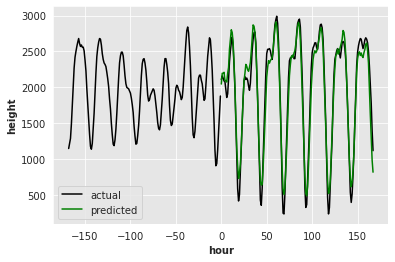

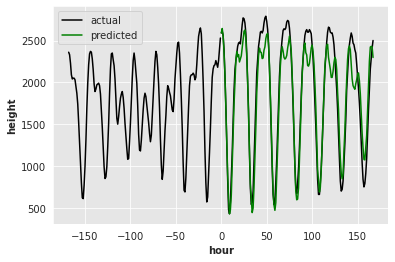

MAE:  171.05681852428245
MAPE:  12.2 %


,model,MAE,MAPE,saved_as
0,LSTM1,164.06,0.12,\LSTM_1.h5
1,GRU_1,190.33,0.14,\GRU_1.h5
2,Conv_GRU_1,171.06,0.12,\Conv_GRU_1.h5


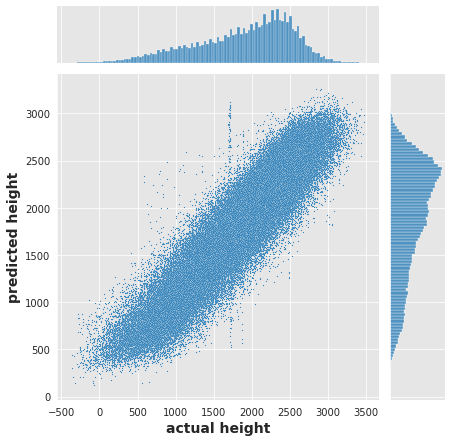

In [13]:
kernal_size = 4
strides = 2

model = keras.models.Sequential(name='Conv_GRU_1')
model.add(keras.layers.Conv1D(filters=20, kernel_size=kernal_size, strides=strides, padding="valid",
                        input_shape=[None, len(train.columns)]))
model.add(keras.layers.GRU(20, return_sequences=True))
model.add(keras.layers.GRU(20, return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(future_steps)))


model.compile(loss="mse", optimizer="adam", metrics=[end_sequence_mse])
history = model.fit(x_train, y_train[:, kernal_size-1::strides], epochs=20,
                    validation_data=(x_val, y_val[:, kernal_size-1::strides]))


save_model(model)
plot_history(history)
x_test_rescaled, y_test_rescaled, y_pred = get_predictions(model) 
plot_predictions(y_pred)
visualize_results(y_pred)
mae, mape = score_model(y_pred)

results = results.append({'model': model.name, 'MAE': mae, 'MAPE': mape, 'saved_as': str(save_path)+'\\'+str(model.name)+'.h5'}, ignore_index=True)
results.to_csv(save_path+'\\'+'results.csv')

display(results)
